# SAM3 segmentation (force in sam3d-unified)

This notebook attempts to run SAM3 in the existing `sam3d-unified` env (no new env).
You must have HF access to `facebook/sam3` and be logged in.


In [5]:
import sys
import subprocess

print('python:', sys.version.replace('\n', ' '))
try:
    import torch
    print('torch:', torch.__version__, 'cuda:', torch.version.cuda)
    print('cuda available:', torch.cuda.is_available())
except Exception as exc:
    print('torch import failed:', exc)

try:
    print(subprocess.check_output(['nvidia-smi', '-L']).decode().strip())
except Exception as exc:
    print('nvidia-smi failed:', exc)


python: 3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:27:40) [GCC 11.3.0]
torch: 2.5.1+cu121 cuda: 12.1
cuda available: True
GPU 0: NVIDIA L4 (UUID: GPU-d5d960f0-c4f2-6b2a-3919-dadb31ac0819)


In [3]:
# Force install SAM3 without changing core deps (no torch upgrade).
# If this fails, remove --no-deps and retry (may change torch/cu versions).
%pip install --upgrade pip
%pip install --ignore-requires-python --no-deps git+https://github.com/facebookresearch/sam3.git
%pip install -U huggingface_hub iopath pillow


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/facebookresearch/sam3.git to /tmp/pip-req-build-ib_poaw5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam3.git /tmp/pip-req-build-ib_poaw5
  Resolved https://github.com/facebookresearch/sam3.git to commit 11dec2936de97f2857c1f76b66d982d5a001155d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-py3-none-any.whl size=1865877 sha256=0e739e3de2d7c8fb2d7fa496e725a89780a438dc6e761dece9f111a25d2d0449
  Stored in directory: /tmp/pip-ephem-wheel-cache-dotlwtl4/wheels/84/f8/ec/511f09ef871d45c08c768d555be63ecf84f8d40ecf961070cd
Successfully built sam3
Note: you may need to restart the kernel to use updated packages.
  Using cached huggingface_hub-1.3.1-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from huggingface_hub import HfFolder
print('HF token present:', bool(HfFolder.get_token()))


HF token present: True


In [3]:

import huggingface_hub
from huggingface_hub.errors import RemoteEntryNotFoundError
print("huggingface_hub:", huggingface_hub.__version__)

huggingface_hub: 1.3.1


In [1]:
import os
import numpy as np
from PIL import Image
import torch

from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

image_path = '/content/sam3d-ready/notebook/example/kids-room/image.jpg'
prompt = 'chair'  # change this
out_dir = '/content/sam3d-ready/notebook/example/kids-room'
os.makedirs(out_dir, exist_ok=True)
mask_path = os.path.join(out_dir, '0.png')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = build_sam3_image_model(device=device)
processor = Sam3Processor(model)

image = Image.open(image_path).convert('RGB')
state = processor.set_image(image)
output = processor.set_text_prompt(state=state, prompt=prompt)

masks = output['masks']
scores = output.get('scores')
if masks.ndim == 4:
    masks = masks[:, 0]
if scores is not None:
    idx = int(scores.argmax().item())
else:
    idx = 0

mask = masks[idx].float().cpu().numpy()
mask_bin = (mask > 0).astype(np.uint8) * 255
Image.fromarray(mask_bin).save(mask_path)
print('mask saved:', mask_path, 'score:', float(scores[idx]) if scores is not None else 'n/a')


/content/sam3d-ready/micromamba/envs/sam3d-unified/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

mask saved: /content/sam3d-ready/notebook/example/kids-room/0.png score: 0.9632449150085449


(-0.5, 1917.5, 2559.5, -0.5)

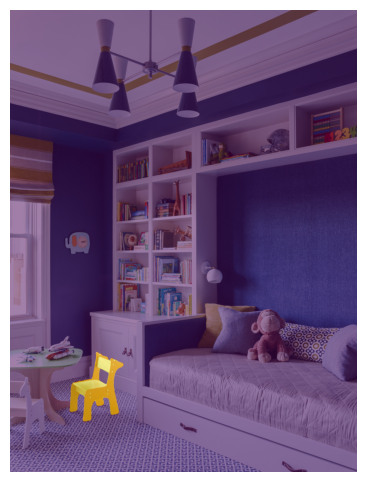

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.imshow(mask_bin, alpha=0.5)
plt.axis('off')


In [6]:
import gc
import torch

# 删除大对象（按需补充）
for name in ["model", "processor", "output", "masks", "mask", "mask_bin", "state", "image"]:
    if name in globals():
        del globals()[name]

gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
